# 1.Autoencoder KERAS

docs lib: https://keras.io/api/models/

# 2.PREPARATION

In [1]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-01-25 15:40:17.533359: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 15:40:19.901990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-01-25 15:40:19.903391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-01-25 15:40:19.904922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [2]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pyarrow
import pyarrow as pa
import pandas as pd
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

import common
import lib.utils as utils
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string

run, client = common.init_experiment(name='notebook')

2023-01-25 15:40:22,778[INFO][140013028075328-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [3]:
#L_fsource = '/cic/dataset/featured_extracted/cic2018/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv.00001.csv.00006.csv' #@param {type:"string"}
#L_fdata: Dataset = read_csv_in_dir_label_string(L_fsource)
#L_fcount: DataFrame = L_fdata.groupby(LABEL).aggregate(Count()).to_pandas()

In [4]:
# Importing the finla file in pandas dataframe
#df = pd.read_csv('/cic/dataset/featured_extracted/cic2018/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv.00001.csv.00006.csv', sep = ',')
#df = L_fdata.to_pandas()
df = utils.combine_csv('/cic/dataset/featured_extracted/cic2018/*.csv').fillna(0.).replace([np.inf, -np.inf], 0)

## Data preview

In [5]:
print('df=', df.shape)
df.head()

df= (16232943, 84)


,dst_port,protocol,timestamp,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,flow_byts_s,flow_pkts_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_tot,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_tot,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_len,bwd_header_len,fwd_pkts_s,bwd_pkts_s,pkt_len_min,pkt_len_max,pkt_len_mean,pkt_len_std,pkt_len_var,fin_flag_cnt,syn_flag_cnt,rst_flag_cnt,psh_flag_cnt,ack_flag_cnt,urg_flag_cnt,cwe_flag_count,ece_flag_cnt,down_up_ratio,pkt_size_avg,fwd_seg_size_avg,bwd_seg_size_avg,fwd_byts_b_avg,fwd_pkts_b_avg,fwd_blk_rate_avg,bwd_byts_b_avg,bwd_pkts_b_avg,bwd_blk_rate_avg,subflow_fwd_pkts,subflow_fwd_byts,subflow_bwd_pkts,subflow_bwd_byts,init_fwd_win_byts,init_bwd_win_byts,fwd_act_data_pkts,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label,flow_id,src_ip,src_port,dst_ip
0,3389,6,02/03/2018 12:44:37,1671120,8,7,1144.0,1581.0,677.0,0.0,143.0,227.969923,1173.0,0.0,225.857143,430.098604,1630.642922,8.976016,119365.71430,245307.58950,953114.0,130.0,1671120.0,238731.4286,385183.9796,1107742.0,11022.0,1577140.0,262856.6667,338806.3198,953114.0,105172.0,0,0,0,0,172,152,4.787209,4.188808,0.0,1173.0,170.312500,319.402717,102018.095800,0,0,1,1,0,0,0,1,0.0,181.666667,143.0,225.857143,0,0,0,0,0,0,8,1144,7,1581,8192,62856,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0.0,0.0,0.0,0.0
1,53,17,02/03/2018 09:00:29,170234,2,2,88.0,200.0,44.0,44.0,44.0,0.000000,100.0,100.0,100.000000,0.000000,1691.788949,23.497069,56744.66667,97423.01311,169239.0,387.0,169847.0,169847.0000,0.0000,169847.0,169847.0,169626.0,169626.0000,0.0000,169626.0,169626.0,0,0,0,0,16,16,11.748534,11.748534,44.0,100.0,66.400000,30.672463,940.800000,0,0,0,0,0,0,0,0,1.0,83.000000,44.0,100.000000,0,0,0,0,0,0,2,88,2,200,-1,-1,1,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0.0,0.0,0.0,0.0
2,63932,6,02/03/2018 08:48:20,97,2,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,20618.556700,97.00000,0.00000,97.0,97.0,97.0,97.0000,0.0000,97.0,97.0,0.0,0.0000,0.0000,0.0,0.0,0,0,0,0,40,0,20618.556700,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.0,0.000000,0,0,0,0,0,0,2,0,0,0,256,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0.0,0.0,0.0,0.0
3,53,17,02/03/2018 12:32:07,1375,1,1,60.0,134.0,60.0,60.0,60.0,0.000000,134.0,134.0,134.000000,0.000000,141090.909100,1454.545455,1375.00000,0.00000,1375.0,1375.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0,0,0,0,8,8,727.272727,727.272727,60.0,134.0,84.666667,42.723920,1825.333333,0,0,0,0,0,0,0,0,1.0,127.000000,60.0,134.000000,0,0,0,0,0,0,1,60,1,134,-1,-1,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0.0,0.0,0.0,0.0
4,3389,6,02/03/2018 12:55:36,1601004,8,7,1128.0,1581.0,661.0,0.0,141.0,222.623321,1173.0,0.0,225.857143,430.098604,1692.063230,9.369121,114357.42860,245482.94050,953297.0,91.0,1601004.0,228714.8571,385390.5437,1099139.0,6784.0,1509379.0,251563.1667,344562.9507,953297.0,96063.0,0,0,0,0,172,152,4.996864,4.372256,0.0,1173.0,169.312500,317.731274,100953.162500,0,0,1,1,0,0,0,1,0.0,180.600000,141.0,225.857143,0,0,0,0,0,0,8,1128,7,1581,8192,62872,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,0.0,0.0,0.0,0.0


In [6]:
n_features = 79   #@param {type:"integer"}
features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
features = features[0: n_features]
Lfpadding_features = sorted(list(set(features) - set(df.columns)))
df[Lfpadding_features] = 0

print ('features=', features)
print ('Lfpadding_features=', Lfpadding_features)
df[LABEL].value_counts()

features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

Benign                    13484708
DDOS attack-HOIC            686012
DDoS attacks-LOIC-HTTP      576191
DoS attacks-Hulk            461912
Bot                         286191
                            ...   
DoS attacks-Slowloris        10990
DDOS attack-LOIC-UDP          1730
Brute Force -Web               611
Brute Force -XSS               230
SQL Injection                   87
Name: label, Length: 15, dtype: int64

In [7]:
df['c0'] = df[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
df = df[['c0', *features]]
df.columns

Index(['c0', 'ack_flag_cnt', 'active_max', 'active_mean', 'active_min',
       'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len',
       'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std',
       'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min',
       'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags',
       'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio',
       'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s',
       'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min',
       'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg',
       'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean',
       'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max',
       'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std',
       'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg',
       'fwd_seg_size_min', 'fwd_urg_flags', '

In [8]:
# Adding prefix to column names so that we can easily reference them
# Original file did not contain column names so pandas creates numeric column names automatically that cannot be referenced easily 
#df = df.add_prefix('c')
df.columns

Index(['c0', 'ack_flag_cnt', 'active_max', 'active_mean', 'active_min',
       'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len',
       'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std',
       'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min',
       'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags',
       'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio',
       'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s',
       'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min',
       'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg',
       'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean',
       'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max',
       'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std',
       'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg',
       'fwd_seg_size_min', 'fwd_urg_flags', '

In [9]:
# Counting the data points of diffrent labels 
df['c0'].value_counts()

0    13484708
1     2748235
Name: c0, dtype: int64

In [10]:
df.describe()

,c0,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
count,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,16232943.0,16232943.0,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,16232943.0,1.623294e+07,16232943.0,1.623294e+07,16232943.0,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,16232943.0,16232943.0,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,16232943.0,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07,1.623294e+07
mean,1.692999e-01,3.316020e-01,2.623920e+05,1.728776e+05,1.154657e+05,8.644097e+04,0.0,0.0,1.330935e+02,2.612947e+06,8.241998e+05,2.912304e+05,8.511741e+05,7.597374e+06,3.501495e+02,1.130759e+02,2.647805e+01,1.315657e+02,0.0,1.531596e+04,0.0,1.130759e+02,0.0,1.638027e-04,4.964363e-01,9.164073e+03,1.873986e-01,4.795434e-03,2.555186e+05,1.181380e+07,6.602697e+06,3.335397e+06,2.321854e+06,1.275574e+06,5.198848e+04,1.989528e+01,0.0,0.0,2.575408e+02,6.409625e+06,3.661300e+06,2.409649e+06,1.402965e+06,1.152313e+07,2.007620e+02,5.031274e+01,1.107600e+01,7.084147e+01,0.0,3.667251e+04,4.389543e-02,5.031274e+01,1.799267e+01,1.638027e-04,5.428144e+06,5.016958e+06,4.685631e+06,2.866491e+05,8.689131e+03,8.787202e+03,3.893461e+02,7.762634e+01,1.094256e+01,1.214681e+02,4.117054e+04,8.954040e+01,8.754113e+00,3.920842e-01,1.873980e-01,2.217065e+04,4.730909e+03,6.312706e+00,9.730373e+02,2.353319e+01,4.389543e-02,6.312706e+00,2.353319e+01,4.730931e+03,9.730373e+02,4.171302e-02
std,3.750166e-01,4.707888e-01,3.319230e+06,2.505927e+06,2.114145e+06,1.514575e+06,0.0,0.0,3.265496e+03,1.024426e+07,4.340497e+06,3.825444e+06,3.376930e+06,2.586288e+07,4.974234e+02,1.641056e+02,5.097873e+01,2.042592e+02,0.0,9.241990e+04,0.0,1.641056e+02,0.0,1.279750e-02,9.967273e-01,1.892224e+04,3.902312e-01,6.908283e-02,3.657059e+06,4.940124e+08,6.595104e+08,2.229483e+08,7.476211e+08,3.381128e+08,2.639734e+05,1.519917e+03,0.0,0.0,1.226352e+04,6.595084e+08,2.229602e+08,7.476241e+08,3.381193e+08,4.940071e+08,3.035091e+02,6.050561e+01,2.422938e+01,1.164407e+02,0.0,2.133241e+05,2.048624e-01,6.050561e+01,7.693845e+00,1.279750e-02,6.253704e+08,2.633178e+08,6.365202e+07,1.691887e+08,2.061931e+04,1.623560e+04,5.141581e+02,1.037008e+02,2.261941e+01,1.625302e+02,2.129773e+05,1.082233e+02,4.920117e+00,4.882153e-01,3.902307e-01,2.703182e+04,2.344556e+05,1.640256e+02,6.216906e+04,1.521137e+03,2.048624e-01,1.64025

In [11]:
# splitting into train test data
train_data, test_data, train_labels, test_labels = train_test_split(df.values, df.values[:, 0:1], test_size = 0.2, random_state = 111)


In [12]:
# Initializing a MinMax Scaler
scaler = MinMaxScaler()

# Fitting the train data to the scaler
data_scaled = scaler.fit(train_data)

In [13]:
# Scaling dataset according to weights of train data
train_data_scaled = data_scaled.transform(train_data)
test_data_scaled = data_scaled.transform(test_data)

In [14]:
train_data.shape

(12986354, 80)

In [15]:
# Making pandas dataframe for the normal and anomaly train data points
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:, 1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

In [16]:
anomaly_train_data

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [17]:
# Making pandas dataframe for the normal and anomaly test data points
normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:, 1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

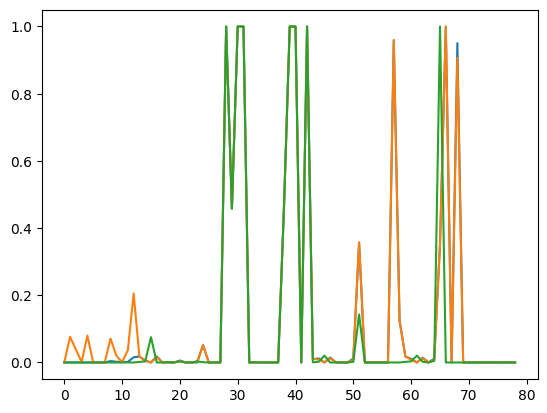

In [18]:
# plotting the first three normal data points
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])

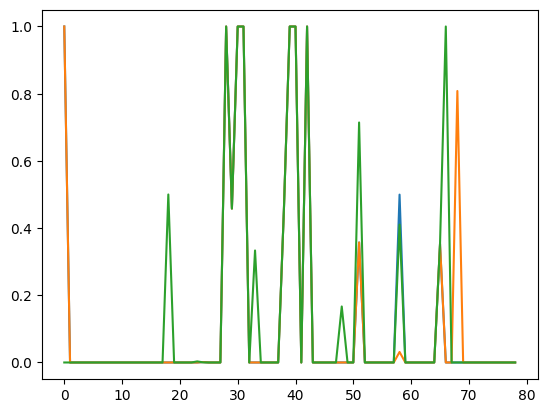

In [19]:
# plotting the first three anomaly data points
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])

In [20]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Sequential([
                                Dense(64, activation='relu'),
                                Dense(32, activation='relu'),
                                Dense(16, activation='relu'),
                                Dense(8, activation='relu')
    ])

    self.decoder = Sequential([
                               Dense(16, activation='relu'),
                               Dense(32, activation='relu'),
                               Dense(64, activation='relu'),
                               Dense(df.shape[1] - 1, activation='sigmoid')
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [21]:
# Instantiating the Autoencoder
model = Autoencoder()

# creating an early_stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience = 2,
                               mode = 'min')

# Compiling the model
model.compile(optimizer = 'adam',
              loss = 'mae')

2023-01-25 15:53:50.116335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-01-25 15:53:50.117119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-01-25 15:53:50.117863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-01-25 15:53:50.118562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


In [22]:
# Training the model
history = model.fit(normal_train_data,normal_train_data,
                    epochs = 50,
                    batch_size = 120,
                    validation_data = (train_data_scaled[:,1:], train_data_scaled[:,1:]),
                    shuffle = True,
                    callbacks = [early_stopping])

model.save(f"/usr/local/opnsense/scripts/ml/aicheckpoints/autoencoder_flow79_cic/model")
open(f"/usr/local/opnsense/scripts/ml/aicheckpoints/autoencoder_flow79_cic/model/features.json", "w").write(json.dumps(features))

2023-01-25 15:53:57.228489: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3408728972 exceeds 10% of free system memory.
2023-01-25 15:54:11.174729: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3408728972 exceeds 10% of free system memory.
2023-01-25 15:54:15.672288: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3408728972 exceeds 10% of free system memory.
2023-01-25 15:54:18.831999: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3408728972 exceeds 10% of free system memory.


Epoch 1/50
   27/89893 [..............................] - ETA: 5:52 - loss: 0.4676   

2023-01-25 15:54:25.549506: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


89884/89893 [============================>.] - ETA: 0s - loss: 0.0092

2023-01-25 16:01:14.354504: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4103687864 exceeds 10% of free system memory.
2023-01-25 16:01:45.551593: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.82GiB (rounded to 4103687936)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-01-25 16:01:45.551677: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-01-25 16:01:45.551714: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 49, Chunks in use: 49. 12.2KiB allocated for chunks. 12.2KiB in use in bin. 2.9KiB client-requested in use in bin.
2023-01-25 16:01:45.551732: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# predictions for normal test data points
model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/autoencoder_flow79_cic/model")
encoder_out = model.encoder(normal_test_data).numpy()
decoder_out = model.decoder(encoder_out).numpy()

In [ ]:
encoder_out.shape

In [ ]:
decoder_out.shape

In [ ]:
# plotting normal test data point and its predictiction by the autoencoder
plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')

In [ ]:
# predictions for anomaly test data points
encoder_out_a = model.encoder(anomaly_test_data).numpy()
decoder_out_a = model.decoder(encoder_out_a).numpy()

In [ ]:
# plotting anomaly test data point and its predictiction by the autoencoder
plt.plot(anomaly_test_data[0], 'b')
plt.plot(decoder_out_a[0], 'r')

anomaly_scores = np.abs(anomaly_test_data - decoder_out_a)
print('anomaly_scores=', anomaly_scores)

In [ ]:
# reconstruction loss for normal test data
reconstructions = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_test_data)

# Plotting histogram for recontruction loss for normal test data
plt.hist(train_loss, bins = 10)

In [ ]:
np.mean(train_loss)

In [ ]:
np.std(train_loss)

In [ ]:
# reconstruction loss for anomaly test data
reconstructions_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstructions_a, anomaly_test_data)

# Plotting histogram for recontruction loss for anomaly test data
plt.hist(train_loss_a, bins = 10)

In [ ]:
np.mean(train_loss_a)

In [ ]:
np.std(train_loss_a)

In [ ]:
# setting threshold
threshold = np.mean(train_loss) + 2*np.std(train_loss)

In [ ]:
threshold

In [ ]:
# Plotting the normal and anomaly losses with the threshold
plt.hist(train_loss, bins = 10, label = 'Normal')
plt.hist(train_loss_a, bins = 10, label = 'Anomaly')
plt.axvline(threshold, color='r', linewidth = 3, linestyle = 'dashed', label = '{:0.3f}'.format(threshold))
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
# Number of correct predictions for Normal test data  
preds = tf.math.less(train_loss, threshold)

In [ ]:
tf.math.count_nonzero(preds)

In [ ]:
# Number of correct predictions for Anomaly test data 
preds_a = tf.math.greater(train_loss_a, threshold)

In [ ]:
tf.math.count_nonzero(preds_a)

In [ ]:
preds_a.shape